# Performance improvement with alternative skymaps

Feedback from IVOA application working group included recommendation that we include skymaps already down-sampled to some orders less than the original histogram binning order.

See also: https://github.com/lincc-frameworks/hats-ivoa/issues/16

This should, in theory, speed up rendering of survey preview images.

This notebook tests that theory, using a preliminary implementation of downsampled skymap writing, as well as inferring the best skymap to read based on the requested order.

In [ ]:
from pathlib import Path
from hats.io import file_io
from matplotlib import pyplot as plt
import hats
from hats.inspection import plot_density
import timeit
import warnings

## These lines take a basic point map file and create a new catalog with skymap and 2, 4, 6, 8 downsampled skymaps.

# catalog_dir = Path("/home/delucchi/git/ivoa/skymap/tests/data/small_sky_source skymap")

# point_map = file_io.read_fits_image(catalog_dir/"point_map.fits")

# file_io.write_skymap(point_map, catalog_dir, orders=[2, 4, 6, 8])

In [7]:
catalog = hats.read_hats("/home/delucchi/git/ivoa/skymap/tests/data/small_sky_source")

## Pointmap timings

Pretty simple - this is only using the old (existing) code path, that loads the entire skymap from point_map.fits, and down-samples as appropriate.

Much of the time is spent in rendering, not in reading, since this is a local file.

In [ ]:
point_map_timings = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(10, 0, -1):
        %timeit -v timing plot_density(catalog, order=i);
        print(i)
        print(timing)
        point_map_timings.append(timing)
        plt.close()

1.87 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
1.87 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.71 s ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9
1.71 s ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.65 s ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8
1.65 s ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.63 s ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
1.63 s ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
614 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
614 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
369 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
369 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
297 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4
297 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
297 ms ± 5.82 ms per loop (mean ± std

In [9]:
catalog = hats.read_hats("/home/delucchi/git/ivoa/skymap/tests/data/small_sky_source_skymap")

## Skymap timings

For order=10, we need to read from the order 10 original resolution skymap.

We only have down-sampled skymaps for orders 2, 4, 6, 8, so if we provide an odd number (or 0), the new implementation tries to be a little clever, and fetch just the next highest (e.g. if requesting 5, get the order 6 skymap and downsample).

In [ ]:
skymap_timings = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(10, 0, -1):
        %timeit -v timing plot_density(catalog, order=i);
        print(i)
        print(timing)
        skymap_timings.append(timing)
        plt.close()

1.83 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
1.83 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.69 s ± 9.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9
1.69 s ± 9.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.43 s ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8
1.43 s ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.43 s ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
1.43 s ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
374 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
374 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
130 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5
130 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
76.8 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4
76.8 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
68.1 ms ± 2.83 ms per l

Text(0.5, 1.0, 'Time to render density plot for point map vs skymap')

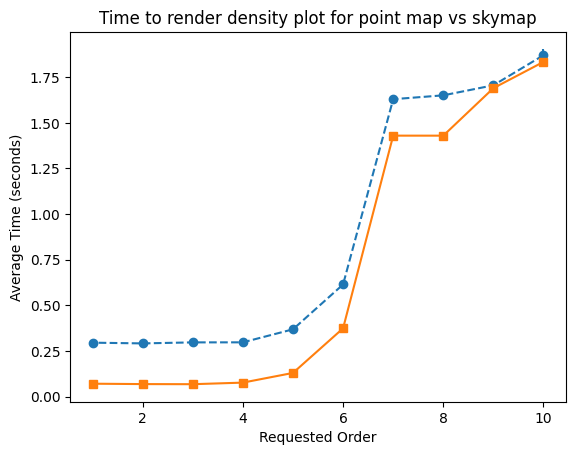

In [13]:
means = [time.average for time in point_map_timings]
std_err = [time.stdev for time in point_map_timings]
orders=range(10, 0, -1)

plt.errorbar(orders, means, yerr=std_err, fmt='o--')

means = [time.average for time in skymap_timings]
std_err = [time.stdev for time in skymap_timings]
orders=range(10, 0, -1)

plt.errorbar(orders, means, yerr=std_err, fmt='s-')

plt.xlabel('Requested Order')
plt.ylabel('Average Time (seconds)')
plt.title('Time to render density plot for point map vs skymap')

## Discussion

We see a very similar trend between the two methods, and much of the time for either is spent in rendering the image.

The large jump from order 6 ot 7 is likely due to additional logic required in `_merge_too_small_pixels`.

It's fun to see that for the skymap implementation, orders 7 and 8 see a very similar speed improvement.